In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Загрузка списка стоп-слов
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))  # NLTK стоп-слова
sklearn_stopwords = set(ENGLISH_STOP_WORDS)  # Sklearn стоп-слова
all_stopwords = nltk_stopwords.union(sklearn_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
def remove_stopwords(text):
    words = text.split()  # Разбиваем текст на слова
    filtered_words = [word for word in words if word.lower() not in all_stopwords]
    return ' '.join(filtered_words)  # Обратно объединяем слова в текст

In [120]:
tickets_path = "all_tickets_processed_improved_v3.csv"
tickets_df = pd.read_csv(tickets_path)

print(tickets_df.shape)
tickets_df.head()

(47837, 2)


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


Unique categories: ['Hardware' 'Access' 'Miscellaneous' 'HR Support' 'Purchase'
 'Administrative rights' 'Storage' 'Internal Project'] 

Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64 



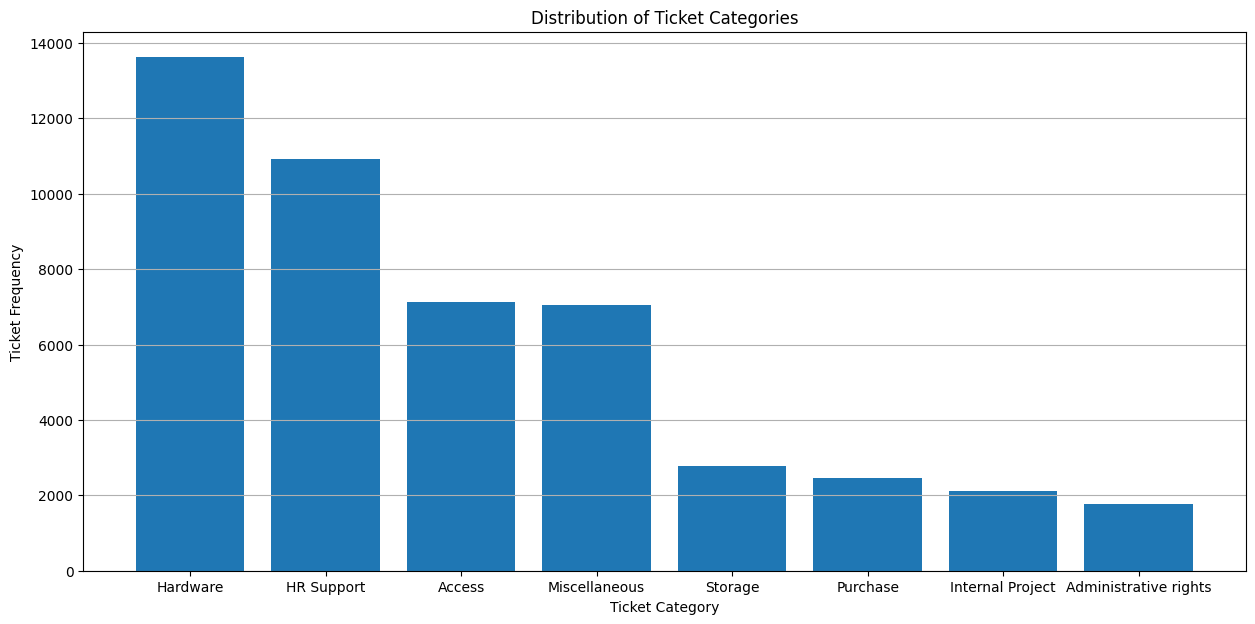

In [121]:
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories")
ax.grid(visible=True, axis = 'y')
plt.show()



(29120, 2)
Hardware count: 5000
HR Support count: 5000
Access count: 5000
Miscellaneous count: 5000
Unique categories: ['Hardware' 'Access' 'Miscellaneous' 'HR Support' 'Purchase'
 'Administrative rights' 'Storage' 'Internal Project'] 

Topic_group
Hardware                 5000
Access                   5000
Miscellaneous            5000
HR Support               5000
Storage                  2777
Purchase                 2464
Internal Project         2119
Administrative rights    1760
Name: count, dtype: int64 



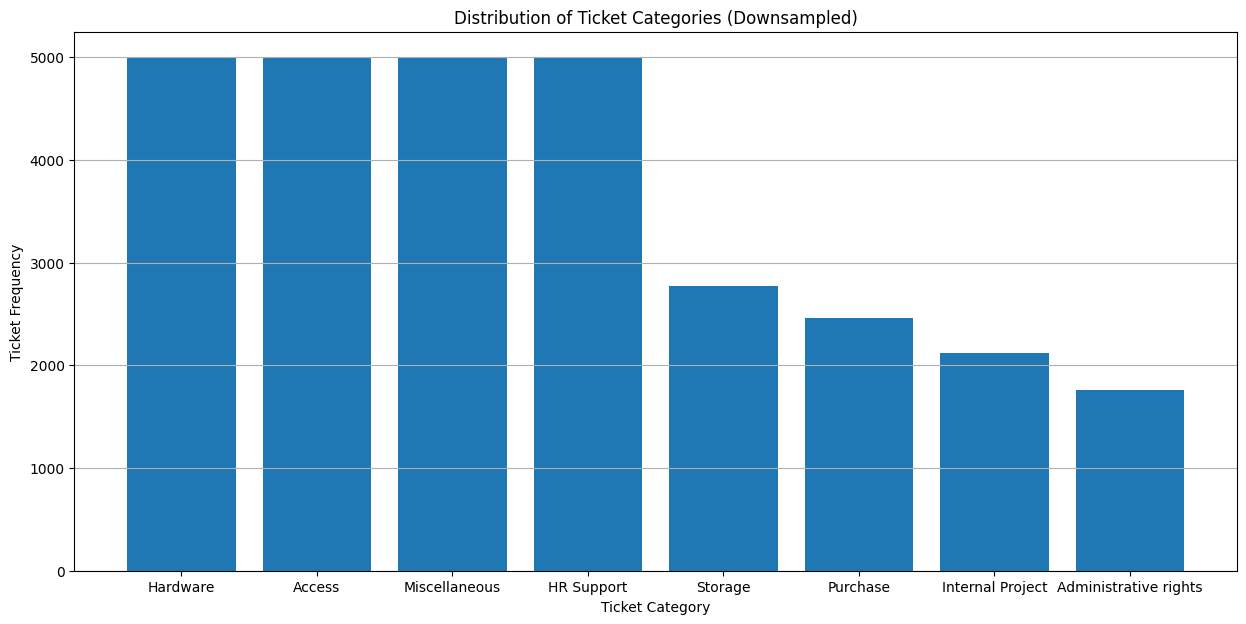

In [122]:
# Get the indices for each category
hardware_indices = tickets_df[tickets_df['Topic_group'] == 'Hardware'].index
hr_support_indices = tickets_df[tickets_df['Topic_group'] == 'HR Support'].index
access_indices = tickets_df[tickets_df['Topic_group'] == 'Access'].index
miscellaneous_indices = tickets_df[tickets_df['Topic_group'] == 'Miscellaneous'].index

# Create a list of indices to drop
indices_to_drop = random.sample(list(hardware_indices), len(hardware_indices) - 5000) + \
                  random.sample(list(hr_support_indices), len(hr_support_indices) - 5000) + \
                  random.sample(list(access_indices), len(access_indices) - 5000) + \
                  random.sample(list(miscellaneous_indices), len(miscellaneous_indices) - 5000)

# Drop the rows
tickets_df_downsample = tickets_df.drop(indices_to_drop)

# Check the number of rows for each category
print(tickets_df_downsample.shape)
print("Hardware count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Hardware'].shape[0])
print("HR Support count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'HR Support'].shape[0])
print("Access count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Access'].shape[0])
print("Miscellaneous count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Miscellaneous'].shape[0])
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df_downsample['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df_downsample['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories (Downsampled)")
ax.grid(visible=True, axis = 'y')
plt.show()

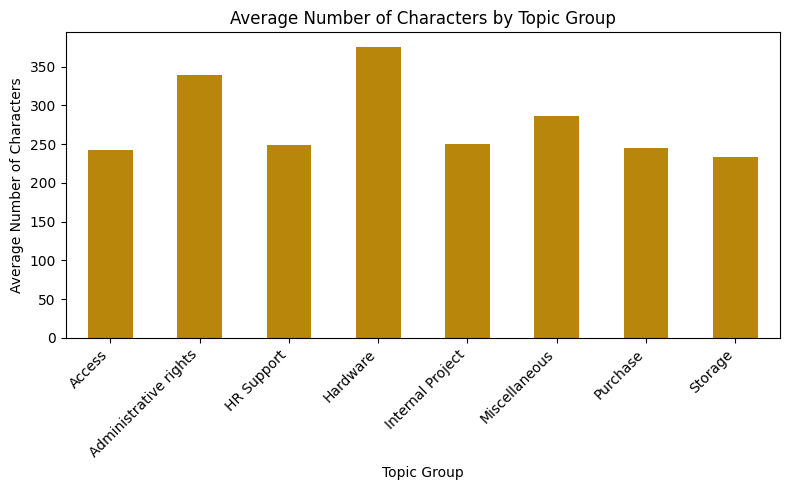

In [123]:
# Average number of characters for each topic group
avg_chars_by_group = tickets_df.groupby('Topic_group')['Document'].apply(lambda x: x.str.len().mean())
plt.figure(figsize=(8, 5))
avg_chars_by_group.plot(kind='bar', color='darkgoldenrod')
plt.title('Average Number of Characters by Topic Group')
plt.xlabel('Topic Group')
plt.ylabel('Average Number of Characters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Most common words for all tickets:


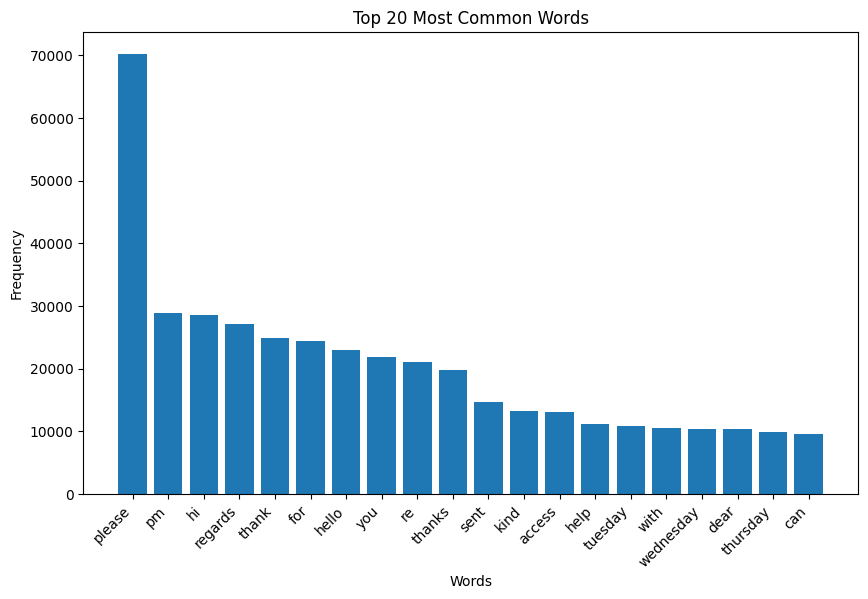

In [124]:
from collections import Counter
from wordcloud import WordCloud
all_words = ' '.join(tickets_df['Document']).split()
# Frequency Analysis
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)  # Get the 20 most common words
# Print header
print("Most common words for all tickets:")



# Visualization - Bar Chart
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [125]:
# Удаление стоп-слов
tickets_df_downsample['Document'] = tickets_df_downsample['Document'].apply(remove_stopwords)

In [126]:
# Split the data into training/validation (95%) and testing (5%) sets
testing_samples = int(len(tickets_df_downsample) * 0.05)
tickets_df_test = tickets_df_downsample[:testing_samples]
tickets_df_train_val = tickets_df_downsample[testing_samples:]

# Split the rest of the data into training (80%) & validation (20%) sets
training_samples = int(len(tickets_df_train_val) * 0.8)
tickets_df_train = tickets_df_train_val[:training_samples]
tickets_df_val = tickets_df_train_val[training_samples:]

print("Training: ", tickets_df_train.shape)
print("Validation: ", tickets_df_val.shape)
print("Testing: ", tickets_df_test.shape)


Training:  (22131, 2)
Validation:  (5533, 2)
Testing:  (1456, 2)


In [127]:
# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
# Max length: if < 200, pad with zeros. if longer, truncate

# Use the text vectorization layer to normalize, split, and map strings to integers.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = keras.layers.TextVectorization(
    max_tokens=10000,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=200
)
# Call adapt on the Training dataset to build the vocabulary.
vectorize_layer.adapt(tickets_df_train['Document'].values)
VOCAB_SIZE = len(vectorize_layer.get_vocabulary())
print(VOCAB_SIZE)
# Vectorize the ticket text ('Document') in the training, validation & testing dataset
train_text = vectorize_layer(tickets_df_train['Document'].values)
val_text = vectorize_layer(tickets_df_val['Document'].values)
test_text = vectorize_layer(tickets_df_test['Document'].values)

print("Training: ", train_text.shape)
print("Validation: ", val_text.shape)
print("Testing: ", test_text.shape)

train_text
# One-hot encode the labels ('Topic_group')
train_labels = pd.get_dummies(tickets_df_train['Topic_group']).to_numpy()
val_labels = pd.get_dummies(tickets_df_val['Topic_group']).to_numpy()
test_labels = pd.get_dummies(tickets_df_test['Topic_group']).to_numpy()





print("Training: ", train_labels.shape)
print("Validation: ", val_labels.shape)
print("Testing: ", test_labels.shape)

train_labels
# Use the model_checkpoint_callback to save our best checkpoint in terms of validation accuracy.

def save_best_model(checkpoint_path):

    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    return model_checkpoint_callback


# This function is used to display the history the train/test accuracy/loss of the Keras training.

def display_training_loss_and_accuracy(history):

    plt.figure(figsize=(20,4))

    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


# Define function to display confusion matrix & classification report

def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20,6))

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=1)
    actual_y_train_index = actual_y_train.argmax(axis=1)
    y_test_index = y_test.argmax(axis=1)
    actual_y_test_index = actual_y_test.argmax(axis=1)


    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, actual_y_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Print the second Confusion Matrix for the test data
    #
    cm = confusion_matrix(y_test_index, actual_y_test_index)


    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_train_index, y_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_test_index, y_test_index, target_names=labels))

9239
Training:  (22131, 200)
Validation:  (5533, 200)
Testing:  (1456, 200)
Training:  (22131, 8)
Validation:  (5533, 8)
Testing:  (1456, 8)


In [128]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

# Отключаем маскирование, так как фиксированная длина делает его избыточным
embedded = keras.layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    mask_zero=False  # Отключаем маскирование
)(inputs)

x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)

# Удаление маски перед Conv1D
x = keras.layers.Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)

avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)  # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#model_CNN_GRU.summary()


In [129]:
def save_best_model(checkpoint_path):
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,  # Имя файла
        save_weights_only=False,  # Сохранять всю модель
        monitor='val_accuracy',  # Метрика, по которой отслеживается лучшая модель
        mode='max',  # Выбираем максимальное значение метрики
        save_best_only=True  # Сохранять только лучшую модель
    )
    return model_checkpoint_callback

history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text,
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7E_bilstm.keras')]
)


Epoch 1/7
692/692 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - accuracy: 0.2001 - loss: 1.9819 - val_accuracy: 0.5133 - val_loss: 1.4183
Epoch 2/7
692/692 ━━━━━━━━━━━━━━━━━━━━ 77s 112ms/step - accuracy: 0.6155 - loss: 1.0592 - val_accuracy: 0.5872 - val_loss: 1.1247
Epoch 3/7
692/692 ━━━━━━━━━━━━━━━━━━━━ 78s 112ms/step - accuracy: 0.7242 - loss: 0.8027 - val_accuracy: 0.6414 - val_loss: 1.0028
Epoch 4/7
692/692 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.7750 - loss: 0.6984 - val_accuracy: 0.6843 - val_loss: 0.9741
Epoch 5/7
692/692 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.8047 - loss: 0.5914 - val_accuracy: 0.7206 - val_loss: 0.8888
Epoch 6/7
692/692 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.8326 - loss: 0.5362 - val_accuracy: 0.7528 - val_loss: 0.7874
Epoch 7/7
692/692 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.8508 - loss: 0.4757 - val_accuracy: 0.7573 - val_loss: 0.7825


In [130]:
model_CNN_GRU.save("my_model.keras")


loaded_model = keras.models.load_model("my_model.keras", custom_objects={"TextVectorization": vectorize_layer})

In [134]:
categories = sorted(tickets_df_train['Topic_group'].unique()) # Берём уникальные категории из столбца 'Topic_group'


class_mapping = {i: category for i, category in enumerate(categories)}


def classify_text(text, model, vectorize_layer):
    """
    Классифицирует текст, используя обученную модель.

    Args:
    text (str): Сообщение для классификации.
    model (keras.Model): Обученная модель.
    vectorize_layer (keras.layers.TextVectorization): Слой векторизации текста.
    
    Returns:
    class_id (int): ID предсказанного класса.
    class_probs (list): Вероятности для всех классов.
    """


    text = [text] # Превращаем строку в список для обработки
    vectorized_text = vectorize_layer(text) # Векторизация текста
    vectorized_text = tf.convert_to_tensor(vectorized_text) # Преобразуем в тензор


    predictions = model(vectorized_text, training=False) # Передаём тензор в модель


    class_id = tf.argmax(predictions[0]).numpy() # Индекс класса с наибольшей вероятностью
    class_probs = predictions.numpy().tolist()[0] # Вероятности всех классов

    return class_id, class_probs



new_text = "NOTHING IS WORKING"


class_id, class_probs = classify_text(new_text, loaded_model, vectorize_layer)


#print(f"Предсказанный класс ID: {class_id}")
print(f"Категория: {class_mapping[class_id]}")
#print(f"Вероятности классов: {class_probs}")

Категория: Hardware
